In [ ]:
!pip install transformers datasets evaluate accelerate bert_score

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os, re
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_path = "/kaggle/input/dataset-finetune/dataset_split_wikidepia/data_latih.csv"
valid_path = "/kaggle/input/dataset-finetune/dataset_split_wikidepia/data_validasi.csv"
uji_path   = "/kaggle/input/dataset-finetune/dataset_split_wikidepia/data_uji.csv"

df_train = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)
df_uji   = pd.read_csv(uji_path)

df_train = df_train[['content', 'summary']]
df_valid = df_valid[['content', 'summary']]
df_uji   = df_uji[['content', 'summary']]

In [ ]:
from transformers import AutoTokenizer

model_name = "Wikidepia/IndoT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Enable gradient checkpointing & fp16 for safety
model.gradient_checkpointing_enable()

# Tambah prefix ke input karena model T5 mengandalkan prefix task
prefix = "ringkasan: "

# Fungsi tokenisasi
def tokenize_function(batch):
    inputs = tokenizer(prefix + batch['content'], truncation=True, padding="max_length", max_length=512)
    targets = tokenizer(batch['summary'], truncation=True, padding="max_length", max_length=75)
    inputs['labels'] = targets['input_ids']
    return inputs

train_dataset = Dataset.from_pandas(df_train).map(tokenize_function)
val_dataset   = Dataset.from_pandas(df_valid).map(tokenize_function)
uji_dataset   = Dataset.from_pandas(df_uji).map(tokenize_function)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
uji_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)
uji_loader   = DataLoader(uji_dataset, batch_size=4)

# Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
learning_rate = 1e-5
weight_decay = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
2025-12-02 22:01:35.998630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764712896.022090     151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764712896.029107     151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Map:   0%|          | 0/12021 [00:00<?, ? examples/s]

Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
checkpoint_dir = "/kaggle/working/checkpoints3"
os.makedirs(checkpoint_dir, exist_ok=True)

def get_latest_checkpoint(ckpt_dir):
    files = [f for f in os.listdir(ckpt_dir) if re.match(r"checkpoint_epoch_\d+\.pt", f)]
    if not files:
        return None
    epochs = [int(re.findall(r"\d+", f)[0]) for f in files]
    latest_epoch = max(epochs)
    return os.path.join(ckpt_dir, f"checkpoint_epoch_{latest_epoch}.pt")

# def save_checkpoint(epoch, model, optimizer, train_losses, val_losses):
#     path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
#     torch.save({
#         "epoch": epoch,
#         "model_state_dict": model.state_dict(),
#         "optimizer_state_dict": optimizer.state_dict(),
#         "train_losses": train_losses,
#         "val_losses": val_losses
#     }, path)
#     print(f"[Checkpoint saved] {path}")

def load_checkpoint(path, model, optimizer):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt["epoch"]
    train_losses = ckpt.get("train_losses", [])
    val_losses   = ckpt.get("val_losses", [])
    print(f"[Resumed] from epoch {start_epoch}")
    return start_epoch, train_losses, val_losses

In [ ]:
# Training Loop
train_losses, val_losses = [], []
epochs = 5
grad_accum_steps = 4
best_val_loss = float("inf")

start_epoch = 0
latest_ckpt = get_latest_checkpoint(checkpoint_dir)
if latest_ckpt is not None:
    start_epoch, train_losses, val_losses = load_checkpoint(latest_ckpt, model, optimizer)

for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / grad_accum_steps
        loss.backward()

        train_loss += loss.item()

        # update weight tiap grad_accum_steps
        if (step + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} => Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


    # ✅ Simpan checkpoint jika ini model dengan val_loss terbaik
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_ckpt_path = os.path.join(checkpoint_dir, "best_model.pt")
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses
        }, best_ckpt_path)
        print(f"✅ [Best Checkpoint Updated] Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")

    # ✅ Simpan checkpoint terakhir (last model)
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses
    }, os.path.join(checkpoint_dir, "last_model.pt"))

Epoch 1 [Val]: 100%|██████████| 376/376 [01:32<00:00,  4.05it/s]


Epoch 1 => Train Loss: 5.6588 | Val Loss: 6.5974
✅ [Best Checkpoint Updated] Epoch 1 | Val Loss: 6.5974


Epoch 2 [Val]: 100%|██████████| 376/376 [01:32<00:00,  4.05it/s]


Epoch 2 => Train Loss: 1.4995 | Val Loss: 4.7189
✅ [Best Checkpoint Updated] Epoch 2 | Val Loss: 4.7189


Epoch 3 [Val]: 100%|██████████| 376/376 [01:32<00:00,  4.05it/s]


Epoch 3 => Train Loss: 0.9877 | Val Loss: 2.4218
✅ [Best Checkpoint Updated] Epoch 3 | Val Loss: 2.4218


Epoch 4 [Val]: 100%|██████████| 376/376 [01:32<00:00,  4.07it/s]


Epoch 4 => Train Loss: 0.5920 | Val Loss: 1.5305
✅ [Best Checkpoint Updated] Epoch 4 | Val Loss: 1.5305


Epoch 5 [Val]: 100%|██████████| 376/376 [01:32<00:00,  4.07it/s]


Epoch 5 => Train Loss: 0.3506 | Val Loss: 0.9120
✅ [Best Checkpoint Updated] Epoch 5 | Val Loss: 0.9120


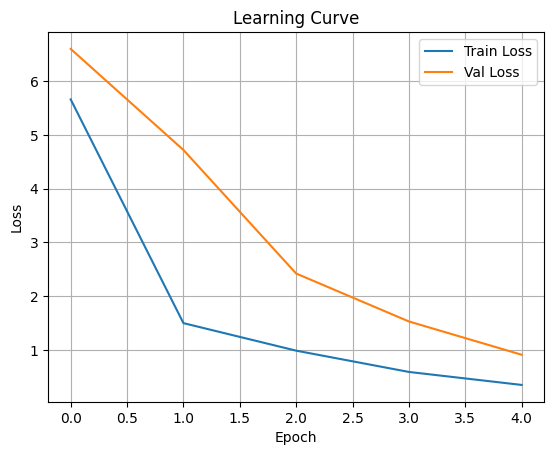

In [ ]:
# Visualisasi Learning Curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Simpan model dan tokenizer ke /kaggle/working
save_path = "/kaggle/working/finetune_wikidepia3"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/kaggle/working/finetune_wikidepia3/tokenizer_config.json',
 '/kaggle/working/finetune_wikidepia3/special_tokens_map.json',
 '/kaggle/working/finetune_wikidepia3/spiece.model',
 '/kaggle/working/finetune_wikidepia3/added_tokens.json',
 '/kaggle/working/finetune_wikidepia3/tokenizer.json')

In [ ]:
# Generate ringkasan dari 5 data uji
model.eval()
for i in range(15):
    content = df_uji.iloc[i]['content']
    reference = df_uji.iloc[i]['summary']

    inputs = tokenizer(content, return_tensors="pt", max_length=512, truncation=True).to(device)
    output = model.generate(inputs['input_ids'], max_length=75, num_beams=4, early_stopping=True)
    predicted = tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"\n📄 Artikel Uji {i+1}")
    print("Content:", content[:300].strip().replace('\n', ' '), "...")
    print("Reference:", reference.strip())
    print("Predicted:", predicted.strip())


📄 Artikel Uji 1
Content: Seorang pengunjung Kebun Raya Bogor mengeluhkan adanya dugaan pungutan liar (pungli) yang dilakukan oleh pengelola terhadapnya dan puluhan rekannya saat gathering menggelar sejumlah perlombaan di lapangan Cappelen, Kebun Raya Bogor. Dugaan pungutan liar (pungli) tersebut diunggah dalam bentuk video ...
Reference: Sekuriti Kebun Raya Bogor menanyakan kepada panitia lantaran mereka tak memberi tahu ke pengelola ihwal acara bersama rombongan.
Predicted: warga Kebun Raya Bogor mengeluhkan adanya dugaan pungli yang dilakukan oleh pengelola Kebun Raya Bogor.

📄 Artikel Uji 2
Content: Lembaga Bantuan Hukum (LBH) Padang mengirim somasi kepada Polda Sumatera Barat pada Rabu, 5 Februari 2025 karena tidak memenuhi putusan Komisi Informasi (KI) Nomor 22/VIII/KISB-PS-M-A/2024. Putusan itu memerintahkan Polda Sumbar dalam 14 hari kerja agar memberikan bekas-berkas kasus kematian Afif Ma ...
Reference: Komisi Informasi mengabulkan permohonan LBH Padang agar Polda Sumatera Ba

In [ ]:
import evaluate

meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")
rouge = evaluate.load("rouge")

predictions = []
references = []

model.eval()
for i in range(len(df_uji)):
    content = df_uji.iloc[i]['content']
    reference = df_uji.iloc[i]['summary']

    inputs = tokenizer(content, return_tensors="pt", max_length=512, truncation=True).to(model.device)
    output = model.generate(
        inputs["input_ids"],
        max_length=75,
        num_beams=4,
        early_stopping=True
    )
    pred = tokenizer.decode(output[0], skip_special_tokens=True)

    predictions.append(pred)
    references.append(reference)

meteor_result = meteor.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="id")
rouge_result = rouge.compute(predictions=predictions, references=references)

print("\n📊 Evaluation on Test Set")
print("-" * 40)

print("🔹 METEOR")
print(f"METEOR     : {meteor_result['meteor']:.4f}")
print("-" * 40)

print("🔹 BERTScore")
print(f"Precision  : {np.mean(bertscore_result['precision']):.4f}")
print(f"Recall     : {np.mean(bertscore_result['recall']):.4f}")
print(f"F1         : {np.mean(bertscore_result['f1']):.4f}")
print("-" * 40)

print("🔹 ROUGE")
print(f"ROUGE-1    : {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2    : {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L    : {rouge_result['rougeL']:.4f}")
print(f"ROUGE-Lsum : {rouge_result['rougeLsum']:.4f}")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


📊 Evaluation on Test Set
----------------------------------------
🔹 METEOR
METEOR     : 0.2258
----------------------------------------
🔹 BERTScore
Precision  : 0.7540
Recall     : 0.7170
F1         : 0.7345
----------------------------------------
🔹 ROUGE
ROUGE-1    : 0.2663
ROUGE-2    : 0.1422
ROUGE-L    : 0.2420
ROUGE-Lsum : 0.2418


In [ ]:
import shutil

#buat folder zip
shutil.make_archive("/kaggle/working/finetune_wikidepia3", 'zip', "/kaggle/working/finetune_wikidepia3")
shutil.make_archive("/kaggle/working/checkpoints3", 'zip', "/kaggle/working/checkpoints3")

'/kaggle/working/checkpoints3.zip'